### Using Jupyter magics for autoreload

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Fast AI imports and other necessary constants

In [2]:
from fastai2.vision.all import *
from nbdev.showdoc import *

set_seed(2)

from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET

### Batch Size

In [4]:
bs = 64
# bs = 32

### Path

In [5]:
PATH = '/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data'

In [6]:
data_path = Path(PATH)
train_data_path = data_path/'train'
data_path.ls()

(#7) [Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/train'),Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/ReadMe.txt'),Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/test'),Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/test_track_id.txt'),Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/tool'),Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/query'),Path('/home/anurag/work/aicity2020/AIC20_track2/AIC20_ReID/data/AIC2020-DataLicenseAgreement.pdf')]

### Convert the XML file to CSV
> Used an online tool for now, will update and add code to do that later
---

### Load the CSV in Pandas Dataframe and explore the data

In [7]:
colnames = ['_imageName', '_vehicleID', '_cameraID']
df = pd.read_csv(data_path/'train/xml_train.csv',header=0)
df.head(10)

,_imageName,_vehicleID,_cameraID
0,021284.jpg,347,c026
1,022106.jpg,308,c033
2,017633.jpg,5,c002
3,019639.jpg,343,c022
4,030656.jpg,388,c016
5,013137.jpg,424,c027
6,032370.jpg,74,c001
7,008022.jpg,44,c003
8,036507.jpg,5,c004
9,008474.jpg,402,c021


### Set up the dataloader

In [8]:
data = ImageDataLoaders.from_csv(train_data_path, 
                                 folder='image_train', 
                                 valid_pct=0.2, 
                                 csv_fname='xml_train.csv',
                                 item_tfms=RandomResizedCrop(460, min_scale=0.75),
                                 bs=bs, 
                                 batch_tfms=[*aug_transforms(size=224, max_warp=0), 
                                             Normalize.from_stats(*imagenet_stats)])

#### Dataloader details
> data.c ==> # of Classes determined by the classifier

> len(data.train_ds) ==> length of Training Set

> len(data.valid_ds) ==> length of Validation Set

In [9]:
data.c, len(data.train_ds), len(data.valid_ds)

(333, 29548, 7387)

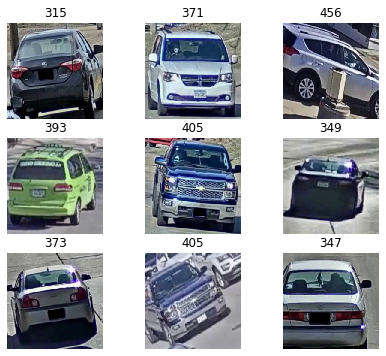

In [10]:
data.show_batch(max_n=9, figsize=(7,6))

## Train model

#### Training with ResNet34 to train faster and then will switch to ResNet50 
> top_k_accuracy --> k=5

In [11]:
avg_precision = APScore()
top_100_accuracy = partial(top_k_accuracy, k=100)
bal_acc = BalancedAccuracy()
precision_micro = Precision(average='micro')
precision_macro = Precision(average='macro')
precision_weighted = Precision(average='weighted')
recall_micro = Recall(average='micro')
recall_macro = Recall(average='macro')
recall_weighted = Recall(average='weighted')

In [12]:
learn = cnn_learner(data, resnet50, metrics=[error_rate, accuracy, 
                                             top_k_accuracy, 
                                             top_100_accuracy,
                                             precision_weighted, 
                                             recall_weighted])

In [13]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,precision_score,recall_score,time
0,3.796014,2.326241,0.495330,0.504670,0.737241,0.980506,0.528132,0.504670,02:39
1,1.203124,0.575118,0.127657,0.872343,0.965480,0.999594,0.883744,0.872343,02:29
2,0.575375,0.249108,0.057940,0.942060,0.988764,1.000000,0.946470,0.942060,02:22
3,0.344650,0.148556,0.036957,0.963043,0.995533,1.000000,0.965723,0.963043,02:22
4,0.217534,0.093996,0.024638,0.975362,0.996345,1.000000,0.977395,0.975362,02:22
5,0.136645,0.069590,0.017598,0.982401,0.997969,1.000000,0.983528,0.982402,02:22
6,0.101647,0.057667,0.013808,0.986192,0.998240,1.000000,0.987027,0.986192,02:22
7,0.080691,0.054693,0.012860,0.987140,0.998240,1.000000,0.987844,0.987140,02:22


/home/anurag/miniconda3/envs/fastai2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
learn.save('stage-1')

In [65]:
np.mean([0.254303,0.804685,0.910057,0.939562,0.958196,0.964786,0.967314,0.968322])

0.845903125

In [66]:
learn.load('stage-1')

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

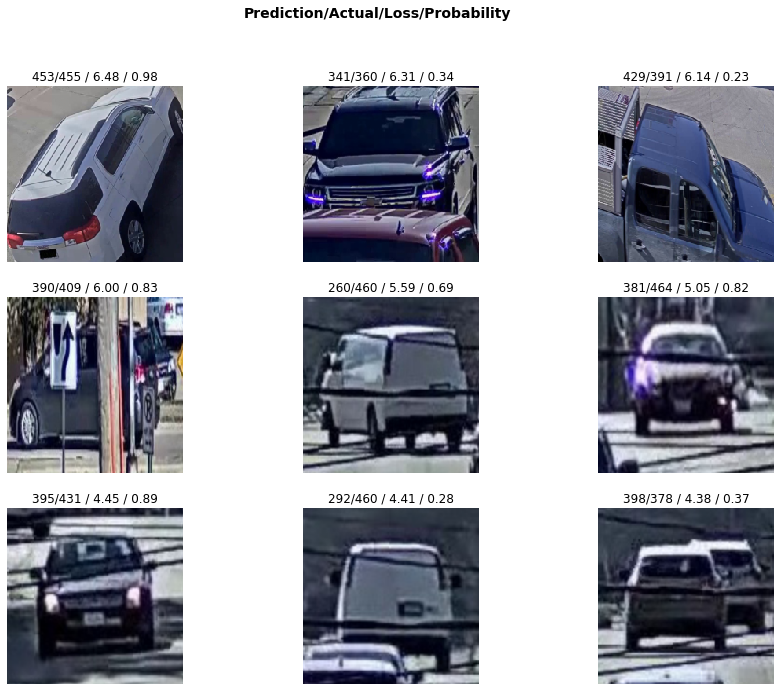

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
# img = Image.open(path/'black'/'00000021.jpg')
data_path/'test'.ls()


AttributeError: 'str' object has no attribute 'ls'

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

In [ ]:
learn.save('stage-2')